# Armado de Dataset Entrenable

## Armado de datos

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [37]:
df_2023 = pd.read_csv('../data/processed/recorridos/trips_2023.csv')
df_2024 = pd.read_csv('../data/processed/recorridos/trips_2024.csv')
df = pd.concat([df_2023, df_2024], ignore_index=True)
print(f"Shape combinado: {df.shape}")
df = df[df['duracion_recorrido'] <= 7200]
df = df.dropna()

Shape combinado: (4777976, 17)


In [38]:
# Crear el rango temporal deseado (con ventanas de 30 minutos)
rango_tiempo = pd.date_range(start='2023-01-01', end='2024-08-31 23:59:59', freq='60min')

# Obtener la lista de estaciones
estaciones = df['id_estacion_destino'].unique()

# Producto cartesiano de estaciones x ventanas
multiindex = pd.MultiIndex.from_product([rango_tiempo, estaciones], names=['ventana_30min', 'id_estacion'])

# Crear el DataFrame base
df_base = pd.DataFrame(index=multiindex).reset_index()

In [39]:
df['ventana_30min'] = pd.to_datetime(df['fecha_destino_recorrido']).dt.floor('30min')
arribos = df.groupby(['ventana_30min', 'id_estacion_destino']).size().reset_index(name='bicis_arriban')

df_base = df_base.merge(arribos, left_on=['ventana_30min', 'id_estacion'], right_on=['ventana_30min', 'id_estacion_destino'], how='left')
df_base['bicis_arriban'] = df_base['bicis_arriban'].fillna(0).astype(int)
df_base.drop(columns=['id_estacion_destino'], inplace=True)


In [40]:
df['ventana_30min'] = pd.to_datetime(df['fecha_origen_recorrido']).dt.floor('30min')
partidas = df.groupby(['ventana_30min', 'id_estacion_origen']).size().reset_index(name='partidas')

# Cambiar nombre para merge
partidas = partidas.rename(columns={
    'id_estacion_origen': 'id_estacion',
    'ventana_30min': 'ventana_30min'
})

# Agregar lag features de partidas
for lag in [1, 2, 3]:
    partidas[f'partidas_lag_{lag}'] = partidas.groupby('id_estacion')['partidas'].shift(lag)

# Unir con df_base
df_base = df_base.merge(partidas, on=['ventana_30min', 'id_estacion'], how='left')


In [41]:
# Asegurar que ventana_30min esté en formato datetime
df_base['ventana_30min'] = pd.to_datetime(df_base['ventana_30min'])

# (Opcional) si querés forzar la visualización con hora en consola/Notebook
df_base['ventana_30min'] = df_base['ventana_30min'].dt.strftime('%Y-%m-%d %H:%M:%S')


In [42]:
# Rellenar con ceros las columnas de partidas y sus lags
cols_lags = ['partidas', 'partidas_lag_1', 'partidas_lag_2', 'partidas_lag_3']
df_base[cols_lags] = df_base[cols_lags].fillna(0).astype(int)

df_base['ventana_30min'] = pd.to_datetime(df_base['ventana_30min'])

In [43]:
# Asegurar que la columna ventana_30min está en datetime en ambos DataFrames
df['ventana_30min'] = pd.to_datetime(df['fecha_destino_recorrido']).dt.floor('30min')
df_base['ventana_30min'] = pd.to_datetime(df_base['ventana_30min'])

# Agrupar por ventana y estación destino + género
conteo_genero = df.groupby(['ventana_30min', 'id_estacion_destino', 'genero']).size().reset_index(name='conteo')

# Pivotear a columnas por género
genero_pivot = conteo_genero.pivot(index=['ventana_30min', 'id_estacion_destino'],
                                   columns='genero',
                                   values='conteo').fillna(0).astype(int)

# Renombrar columnas
genero_pivot = genero_pivot.rename(columns={
    'MALE': 'cant_male',
    'FEMALE': 'cant_female',
    'OTHER': 'cant_other'
}).reset_index()

# Asegurar formato datetime en columna clave del pivot
genero_pivot['ventana_30min'] = pd.to_datetime(genero_pivot['ventana_30min'])

# Merge con df_base
df_base = df_base.merge(genero_pivot,
                        left_on=['ventana_30min', 'id_estacion'],
                        right_on=['ventana_30min', 'id_estacion_destino'],
                        how='left')

# Limpiar columna auxiliar
df_base = df_base.drop(columns=['id_estacion_destino'])

# Rellenar con ceros donde no hubo usuarios de algún género
for col in ['cant_male', 'cant_female', 'cant_other']:
    if col not in df_base.columns:
        df_base[col] = 0
    else:
        df_base[col] = df_base[col].fillna(0).astype(int)


In [44]:
# Extraer latitud y longitud únicas por estación destino
estaciones = df[['id_estacion_destino', 'lat_estacion_destino', 'long_estacion_destino']].drop_duplicates()

# Renombrar columnas para el merge
estaciones = estaciones.rename(columns={
    'id_estacion_destino': 'id_estacion',
    'lat_estacion_destino': 'latitud',
    'long_estacion_destino': 'longitud'
})

# Unir con df_base por id_estacion
df_base = df_base.merge(estaciones, on='id_estacion', how='left')

In [45]:
# Asegurar que ventana_30min esté correctamente creada
df['ventana_30min'] = pd.to_datetime(df['fecha_destino_recorrido']).dt.floor('30min')
df_base['ventana_30min'] = pd.to_datetime(df_base['ventana_30min'])

# Agrupar por ventana, estación destino y modelo de bicicleta
conteo_modelo = df.groupby(['ventana_30min', 'id_estacion_destino', 'modelo_bicicleta']).size().reset_index(name='conteo')

# Pivotear a columnas separadas por modelo
modelo_pivot = conteo_modelo.pivot(index=['ventana_30min', 'id_estacion_destino'],
                                   columns='modelo_bicicleta',
                                   values='conteo').fillna(0).astype(int)

# Renombrar columnas
modelo_pivot = modelo_pivot.rename(columns={
    'FIT': 'cant_fit',
    'ICONIC': 'cant_iconic'
}).reset_index()

# Convertir ventana_30min a datetime si hiciera falta
modelo_pivot['ventana_30min'] = pd.to_datetime(modelo_pivot['ventana_30min'])

# Merge con df_base
df_base = df_base.merge(modelo_pivot,
                        left_on=['ventana_30min', 'id_estacion'],
                        right_on=['ventana_30min', 'id_estacion_destino'],
                        how='left')

# Limpiar columna auxiliar
df_base = df_base.drop(columns=['id_estacion_destino'])

# Rellenar NaNs con ceros
for col in ['cant_fit', 'cant_iconic']:
    if col not in df_base.columns:
        df_base[col] = 0
    else:
        df_base[col] = df_base[col].fillna(0).astype(int)


In [46]:
print(df.shape)
print(df_base.shape)

(4724761, 18)
(8345736, 14)


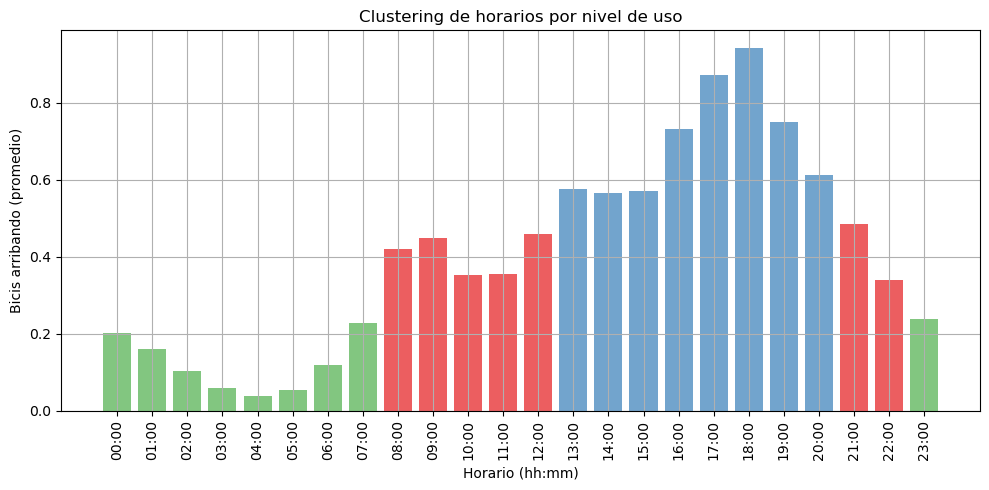

In [47]:
horarios = (
    df_base
    .groupby(df_base['ventana_30min'].dt.strftime('%H:%M'))
    .agg({'bicis_arriban': 'mean', 'partidas': 'mean'})
    .reset_index()
    .rename(columns={'ventana_30min': 'hora_str'})
)

# Escalar
X = horarios[['bicis_arriban', 'partidas']]
X_scaled = StandardScaler().fit_transform(X)

# Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
horarios['cluster'] = kmeans.fit_predict(X_scaled)

# Gráfico
plt.figure(figsize=(10, 5))
plt.bar(horarios['hora_str'], horarios['bicis_arriban'], color=plt.cm.Set1(horarios['cluster']), alpha=0.7)
plt.xticks(rotation=90)
plt.ylabel("Bicis arribando (promedio)")
plt.xlabel("Horario (hh:mm)")
plt.title("Clustering de horarios por nivel de uso")
plt.grid(True)
plt.tight_layout()
plt.show()

In [48]:
# Ordenar por horario para mejor visualización
horarios = horarios.sort_values('hora_str')

# Imprimir los horarios agrupados por cluster
for c in sorted(horarios['cluster'].unique()):
    print(f"\nCluster {c}:")
    print(horarios[horarios['cluster'] == c]['hora_str'].tolist())


Cluster 0:
['08:00', '09:00', '10:00', '11:00', '12:00', '21:00', '22:00']

Cluster 1:
['13:00', '14:00', '15:00', '16:00', '17:00', '18:00', '19:00', '20:00']

Cluster 2:
['00:00', '01:00', '02:00', '03:00', '04:00', '05:00', '06:00', '07:00', '23:00']


In [49]:
nivel_por_hora = {
    '08:00': 'medio', '09:00': 'medio', '10:00': 'medio', '11:00': 'medio', '12:00': 'medio',
    '21:00': 'medio', '22:00': 'medio',
    
    '13:00': 'alto', '14:00': 'alto', '15:00': 'alto', '16:00': 'alto',
    '17:00': 'alto', '18:00': 'alto', '19:00': 'alto', '20:00': 'alto',
    
    '00:00': 'bajo', '01:00': 'bajo', '02:00': 'bajo', '03:00': 'bajo',
    '04:00': 'bajo', '05:00': 'bajo', '06:00': 'bajo', '07:00': 'bajo',
    '23:00': 'bajo'
}
df_base['nivel_horario'] = df_base['ventana_30min'].apply(lambda dt: nivel_por_hora[dt.strftime('%H:00')])


In [50]:
print(df_base.shape)

(8345736, 15)


In [51]:
df_base['es_finde'] = (df_base['ventana_30min'].dt.dayofweek >= 5).astype(int)

In [52]:
print(df_base.shape)

(8345736, 16)


In [53]:
df_movimiento = df_base.groupby('id_estacion').agg({
    'bicis_arriban': 'sum',
    'partidas': 'sum'
}).reset_index()

# Calcular movimiento total
df_movimiento['movimiento_total'] = df_movimiento['bicis_arriban'] + df_movimiento['partidas']

In [54]:
df_estaciones = df_base.groupby('id_estacion')[['bicis_arriban']].sum().reset_index()

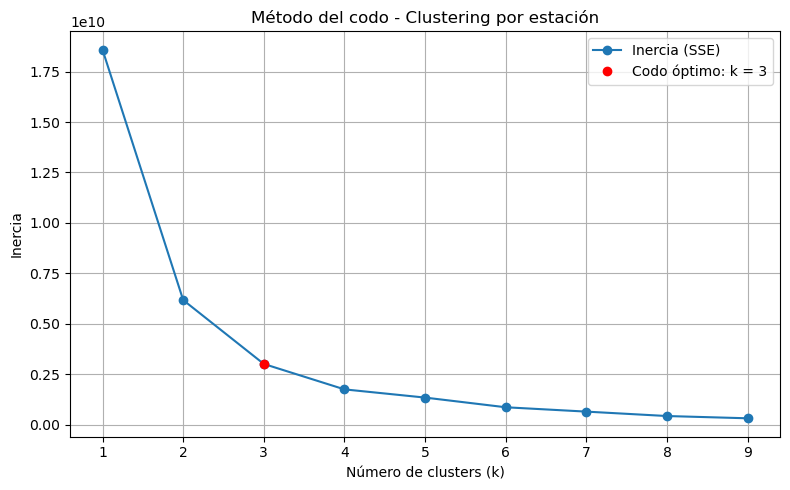

Valor óptimo de k: 3


In [55]:
X = df_estaciones[['bicis_arriban']].values

inercia = []
ks = range(1, 10)

for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inercia.append(kmeans.inertia_)

# Codo automático
x = np.array(list(ks))
y = np.array(inercia)
p1, p2 = np.array([x[0], y[0]]), np.array([x[-1], y[-1]])

def distancia(p, a, b):
    return np.abs(np.cross(b - a, a - p)) / np.linalg.norm(b - a)

distancias = [distancia(np.array([x[i], y[i]]), p1, p2) for i in range(len(x))]
k_optimo = x[np.argmax(distancias)]

# Gráfico
plt.figure(figsize=(8, 5))
plt.plot(ks, inercia, marker='o', label='Inercia (SSE)')
plt.plot(k_optimo, y[np.argmax(distancias)], 'ro', label=f'Codo óptimo: k = {k_optimo}')
plt.title("Método del codo - Clustering por estación")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Inercia")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Valor óptimo de k: {k_optimo}")

kmeans = KMeans(n_clusters=k_optimo, random_state=42)
df_estaciones['cluster'] = kmeans.fit_predict(X)

# Obtener orden desde el centroide
centros = kmeans.cluster_centers_.flatten()
orden = centros.argsort()

# Asignar etiquetas por orden
etiquetas = {orden[0]: 'fantasma'}
if len(orden) >= 3:
    etiquetas[orden[1]] = 'moderada'
    etiquetas[orden[2]] = 'central'
elif len(orden) == 2:
    etiquetas[orden[1]] = 'central'

df_estaciones['tipo_estacion'] = df_estaciones['cluster'].map(etiquetas)



In [56]:
df_base = df_base.merge(df_estaciones[['id_estacion', 'tipo_estacion']], on='id_estacion', how='left')

In [57]:
print(df_base.shape)

(8345736, 17)


In [58]:
df_estaciones['tipo_estacion'].value_counts()

tipo_estacion
fantasma    209
moderada    133
central      41
Name: count, dtype: int64

In [59]:
top_5 = df_movimiento.sort_values('movimiento_total', ascending=False).head(5)
print(top_5)

     id_estacion  bicis_arriban  partidas  movimiento_total
197        289.0          37302     38440             75742
89         131.0          34798     39324             74122
36          54.0          35390     37334             72724
342        515.0          34425     34701             69126
174        254.0          32136     32046             64182


In [60]:
coord_map = df_base[['id_estacion', 'latitud', 'longitud']].drop_duplicates()
df_estaciones = df_estaciones.merge(coord_map, on='id_estacion', how='left')

In [61]:
print(df_base.shape)

(8345736, 17)


In [62]:
# IDs de las 5 estaciones con mayor movimiento
top_5_ids = [289, 131, 54, 515, 254]

# Asegurar tipo float en coordenadas
df_estaciones['latitud'] = df_estaciones['latitud'].astype(float)
df_estaciones['longitud'] = df_estaciones['longitud'].astype(float)

# Obtener coordenadas únicas de las estaciones top
top_5_coords = (
    df_estaciones[df_estaciones['id_estacion'].isin(top_5_ids)]
    .drop_duplicates(subset='id_estacion')
    .set_index('id_estacion')[['latitud', 'longitud']]
)
top_5_coords.index = top_5_coords.index.astype(int)

# Hacer copia y calcular distancias
df_estaciones_dist = df_estaciones.copy()

for i, ref_id in enumerate(top_5_ids, start=1):
    lat_ref = float(top_5_coords.loc[ref_id, 'latitud'])
    lon_ref = float(top_5_coords.loc[ref_id, 'longitud'])

    df_estaciones_dist[f'distancia_central_{i}'] = np.sqrt(
        (df_estaciones_dist['latitud'] - lat_ref) ** 2 +
        (df_estaciones_dist['longitud'] - lon_ref) ** 2
    )

# Asegurarse de tener una fila única por estación antes del merge
df_distancias_unicas = (
    df_estaciones_dist
    .drop_duplicates(subset='id_estacion')
    [['id_estacion'] + [f'distancia_central_{i}' for i in range(1, 6)]]
)

# Merge al dataset base
df_base = df_base.merge(
    df_distancias_unicas,
    on='id_estacion',
    how='left'
)

# Confirmación final
print(f"Cantidad de filas después del merge: {df_base.shape[0]}")
print("Columnas agregadas:", [f'distancia_central_{i}' for i in range(1, 6)])


Cantidad de filas después del merge: 8345736
Columnas agregadas: ['distancia_central_1', 'distancia_central_2', 'distancia_central_3', 'distancia_central_4', 'distancia_central_5']


In [63]:
print(df_base.shape)

(8345736, 22)


In [64]:
df_base.to_csv('../data/handled/dataset.csv', index=False)